In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import sys
import os
sys.path.append(os.path.abspath(".."))
import matplotlib.pyplot as plt
import numpy as np  
from PIL import Image
import kagglehub

# Import own modules
from train.train import SimplePetClassifer
from utils_inference import preprocess_image, predict, visualize_predictions, get_predicted_label
from inference import inference_image

# Download latest version of the dataset from Kaggle
path = kagglehub.dataset_download("tongpython/cat-and-dog")


In [2]:
# Set subclass of Dataset for kaggle Dataset
class PetDataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    
# Load the trained model
model_path = "../models/pretrained_classifier.pth"  # or "scratch_classifier.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please train the model first.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePetClassifer()
model.load_state_dict(torch.load(model_path))
model.to(device)

test_folder = os.path.join(path, "test_set/test_set")
# Define transformations and create DataLoaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = PetDataSet(test_folder, transform=transform)
# Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(test_folder).class_to_idx.items()}
print("Classes found:", target_to_class)


C:\Users\janni\AppData\Local\Temp\ipykernel_10492\3521082897.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Classes found: {0: 'cats', 1: 'dogs'}


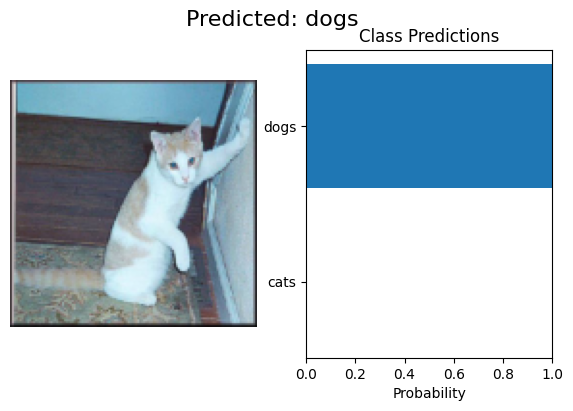

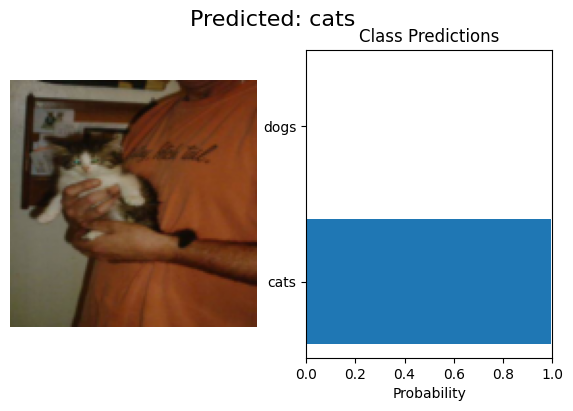

In [3]:
# Get inference on test dataset e.g. first 2 images
for i,item in enumerate(test_dataset):
    if i>=2:
        break
    # Get image and label from dataset and transform into correct format
    image, label = item
    original_image, image_tensor = image, image.unsqueeze(0)
    # Get prediction and visualize
    probabilities = predict(model, image_tensor, device)
    visualize_predictions(original_image.permute(1, 2, 0).numpy(), probabilities, test_dataset.classes)
    
    

Example 0: True label: cats, Predicted: dogs


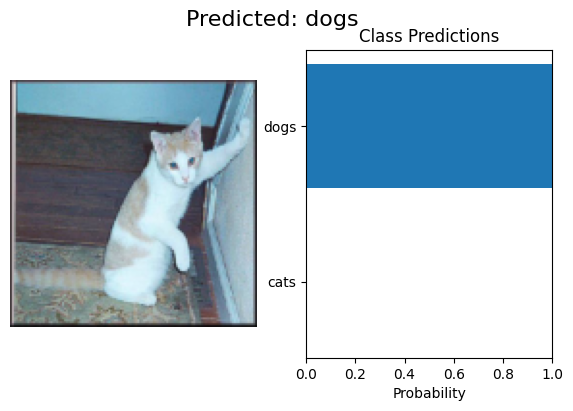

Example 38: True label: cats, Predicted: dogs


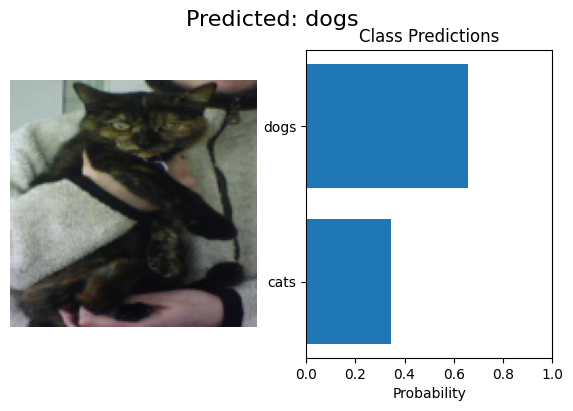

Example 43: True label: cats, Predicted: dogs


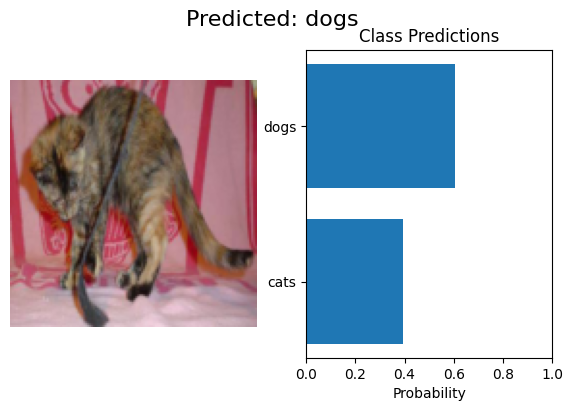

Example 55: True label: cats, Predicted: dogs


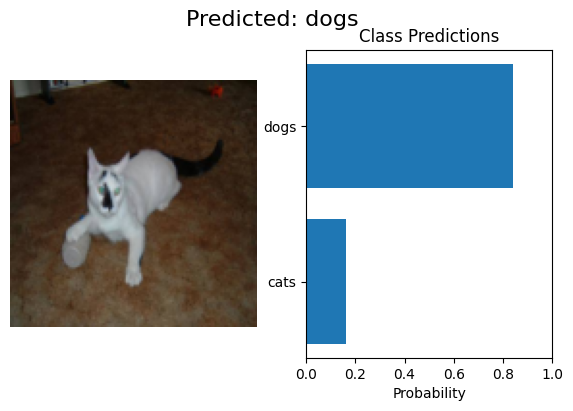

Example 84: True label: cats, Predicted: dogs


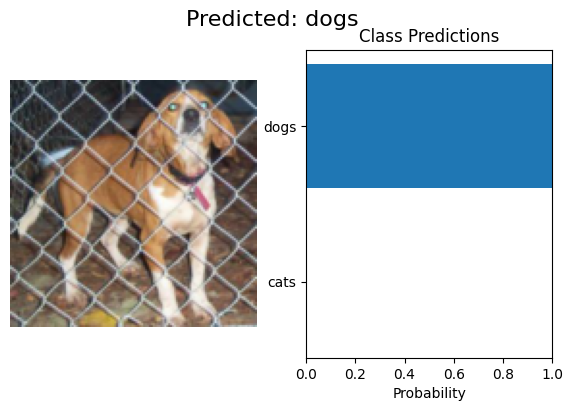

Example 103: True label: cats, Predicted: dogs


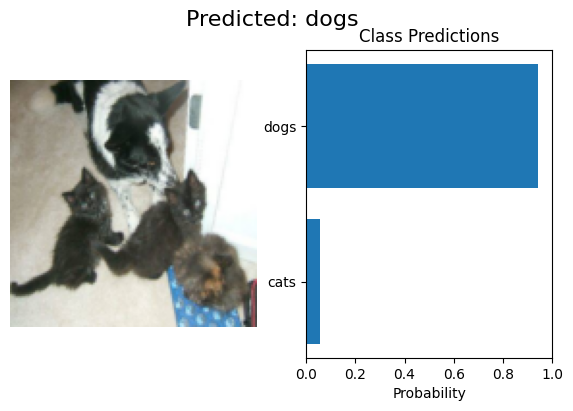

Example 117: True label: cats, Predicted: dogs


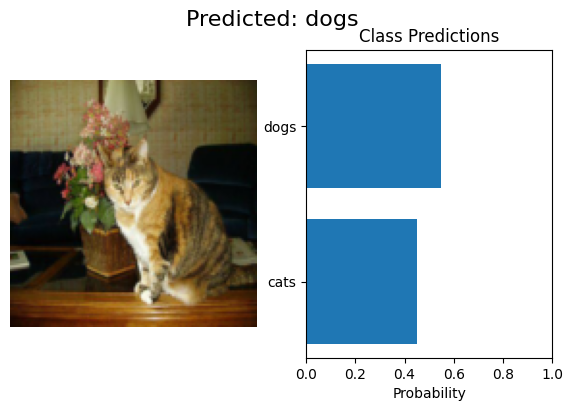

Example 151: True label: cats, Predicted: dogs


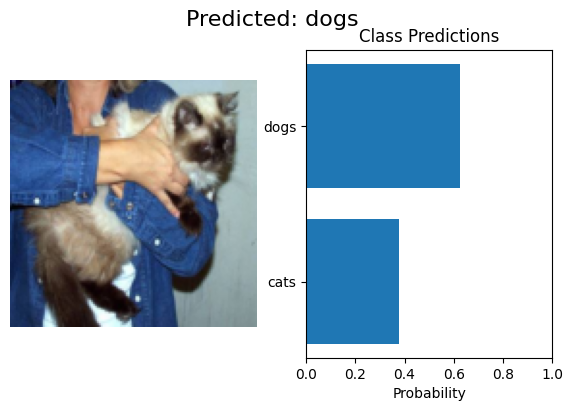

Example 154: True label: cats, Predicted: dogs


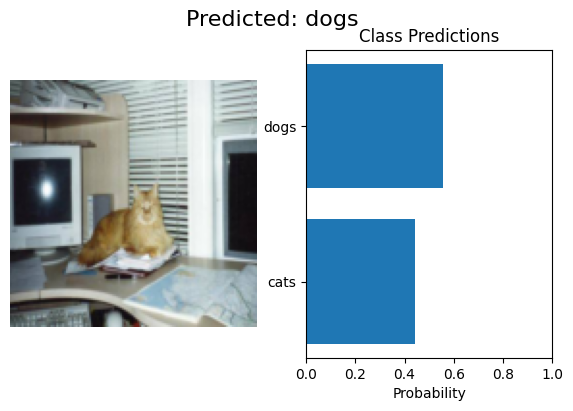

Example 175: True label: cats, Predicted: dogs


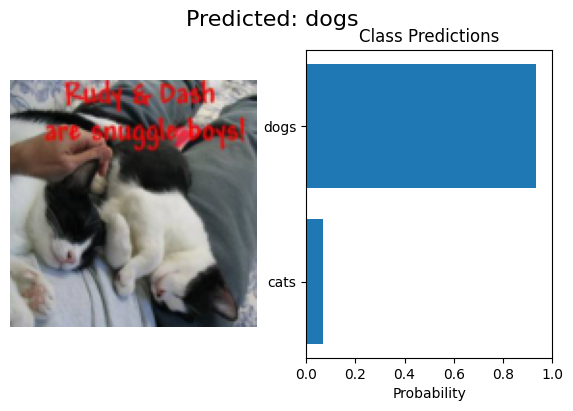

Example 192: True label: cats, Predicted: dogs


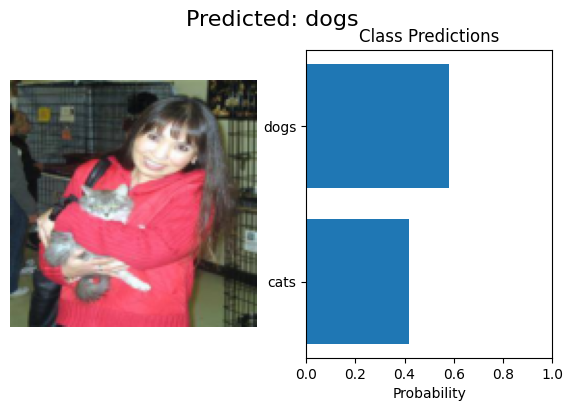

Example 193: True label: cats, Predicted: dogs
Example 299: True label: cats, Predicted: dogs
Example 312: True label: cats, Predicted: dogs
Example 313: True label: cats, Predicted: dogs
Example 350: True label: cats, Predicted: dogs
Example 364: True label: cats, Predicted: dogs
Example 410: True label: cats, Predicted: dogs
Example 418: True label: cats, Predicted: dogs
Example 474: True label: cats, Predicted: dogs
Example 498: True label: cats, Predicted: dogs
Example 576: True label: cats, Predicted: dogs
Example 596: True label: cats, Predicted: dogs
Example 600: True label: cats, Predicted: dogs
Example 614: True label: cats, Predicted: dogs
Example 640: True label: cats, Predicted: dogs
Example 642: True label: cats, Predicted: dogs
Example 645: True label: cats, Predicted: dogs
Example 696: True label: cats, Predicted: dogs
Example 779: True label: cats, Predicted: dogs
Example 791: True label: cats, Predicted: dogs
Example 843: True label: cats, Predicted: dogs
Example 878: 

In [4]:
# Iterate over the whole test dataset and only show wrong predictions
number_of_misclassified = 0  # Counter for misclassified images
number_of_wrong_cats = 0 # Counter for misclassified cats
number_of_wrong_dogs = 0 # Counter for misclassified dogs
number_of_plots = 10 # After this many wrong predictions, stop plotting for santity
for i, item in enumerate(test_dataset):
    # Prepare image and label
    image, label = item
    original_image, image_tensor = image, image.unsqueeze(0)
    # Predict and get probabilities
    probabilities = predict(model, image_tensor, device)
    predicted_label = get_predicted_label(probabilities, target_to_class)
    if predicted_label != test_dataset.classes[label]:
        print(f"Example {i}: True label: {test_dataset.classes[label]}, Predicted: {predicted_label}")
        if number_of_misclassified <= number_of_plots:
            visualize_predictions(original_image.permute(1, 2, 0).numpy(), probabilities, test_dataset.classes)
        number_of_misclassified += 1
        if test_dataset.classes[label] == 'cats':
            number_of_wrong_cats += 1
        else:
            number_of_wrong_dogs += 1

print(f"Total misclassified images: {number_of_misclassified} out of {len(test_dataset)}")
print(f"Total misclassified cats: {number_of_wrong_cats}")
print(f"Total misclassified dogs: {number_of_wrong_dogs}")